In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import History
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Activation 
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
def load_data():
    data = pd.read_csv('/Users/samuelzobev/Downloads/End of year project/data_collection/MSFT.csv', date_parser=True)
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
    data['MA'] = ta.trend.SMAIndicator(data['Close'], window=20).sma_indicator()
    data['EMA'] = ta.trend.EMAIndicator(data['Close'], window=20).ema_indicator()
    bb = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
    data['BB_upper'] = bb.bollinger_hband()
    data['BB_middle'] = bb.bollinger_mavg()
    data['BB_lower'] = bb.bollinger_lband()
    data = data[['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Adj Close', 'RSI', 'MA', 'EMA', 'BB_upper', 'BB_middle', 'BB_lower']]
    data = data.set_index('Date')
    data = data.dropna()
    return data

In [18]:
# remove NaN values
def preprocess_data(data):
    train_size = int(len(data) * 0.7)
    train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    return train_data, test_data, scaler

# prepare the data for LSTM
def prepare_data(data, window_size, num_steps):
    X, Y = [], []
    for i in range(len(data) - window_size - num_steps + 1):
        X.append(data[i:(i + window_size), :])
        Y.append(data[(i + window_size):(i + window_size + num_steps), 1])  # predict 'num_steps' Close values
    X = np.array(X)
    Y = np.array(Y)
    return X, Y


In [19]:
def build_model(trainX, num_steps):
    model = Sequential()
    model.add(LSTM(64, activation='sigmoid', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='sigmoid', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='sigmoid', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(num_steps)) 
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

In [20]:
def train_model(model, trainX, trainY, testX, testY):
    history = model.fit(trainX, trainY, epochs=2000, batch_size=100, shuffle=True, validation_data=(testX, testY), verbose=2)
    return history

In [21]:
def evaluate_model(model, testX, testY, train_data, scaler, num_steps):
    predictions = model.predict(testX)
    dummy_cols_pred = np.zeros((predictions.shape[0], train_data.shape[1] - num_steps))
    predictions = np.hstack((predictions, dummy_cols_pred))
    unscaled_predictions = scaler.inverse_transform(predictions)[:, :num_steps]
    dummy_cols_actual = np.zeros((testY.shape[0], train_data.shape[1] - num_steps))
    actual = np.hstack((testY, dummy_cols_actual))
    unscaled_actual = scaler.inverse_transform(actual)[:, :num_steps]
    mse = mean_squared_error(unscaled_actual, unscaled_predictions)
    mae = mean_absolute_error(unscaled_actual, unscaled_predictions)
    mape = np.mean(np.abs((unscaled_actual - unscaled_predictions) / unscaled_actual)) * 100
    rmse = np.sqrt(mse)
    r2_score = 1 - (np.sum((unscaled_actual - unscaled_predictions)**2) / np.sum((unscaled_actual - np.mean(unscaled_actual))**2))
    if num_steps > train_data.shape[1]:
        raise ValueError(f"Can't predict {num_steps} steps ahead. The maximum number of steps is {train_data.shape[1]}.")
    return mse, mae, mape, rmse, r2_score, unscaled_predictions, unscaled_actual

In [22]:
def save_model(model):
    model.save(r'/Users/samuelzobev/Downloads/End of year project/trained_models/trained_model.h16')

In [23]:
# Load the data
data = load_data()
# Preprocess the data
train_data, test_data, scaler = preprocess_data(data)

In [24]:
# Prepare the data for LSTM
window_size = 10  # Use 7 previous time steps as input features
num_steps = 1  # Predict 1 future time steps
trainX, trainY = prepare_data(train_data, window_size, num_steps)
testX, testY = prepare_data(test_data, window_size, num_steps)
# Build the LSTM model
model = build_model(trainX, num_steps)

Epoch 1/2000
6/6 - 1s - loss: 0.1327 - mse: 0.1327 - val_loss: 0.1043 - val_mse: 0.1043 - 1s/epoch - 221ms/step
Epoch 2/2000
6/6 - 0s - loss: 0.1327 - mse: 0.1327 - val_loss: 0.0733 - val_mse: 0.0733 - 86ms/epoch - 14ms/step
Epoch 3/2000
6/6 - 0s - loss: 0.1142 - mse: 0.1142 - val_loss: 0.0762 - val_mse: 0.0762 - 96ms/epoch - 16ms/step
Epoch 4/2000
6/6 - 0s - loss: 0.1112 - mse: 0.1112 - val_loss: 0.0724 - val_mse: 0.0724 - 100ms/epoch - 17ms/step
Epoch 5/2000
6/6 - 0s - loss: 0.1036 - mse: 0.1036 - val_loss: 0.0716 - val_mse: 0.0716 - 98ms/epoch - 16ms/step
Epoch 6/2000
6/6 - 0s - loss: 0.1029 - mse: 0.1029 - val_loss: 0.0716 - val_mse: 0.0716 - 98ms/epoch - 16ms/step
Epoch 7/2000
6/6 - 0s - loss: 0.1051 - mse: 0.1051 - val_loss: 0.0779 - val_mse: 0.0779 - 99ms/epoch - 16ms/step
Epoch 8/2000
6/6 - 0s - loss: 0.0933 - mse: 0.0933 - val_loss: 0.0702 - val_mse: 0.0702 - 98ms/epoch - 16ms/step
Epoch 9/2000
6/6 - 0s - loss: 0.0895 - mse: 0.0895 - val_loss: 0.0703 - val_mse: 0.0703 - 99ms/e

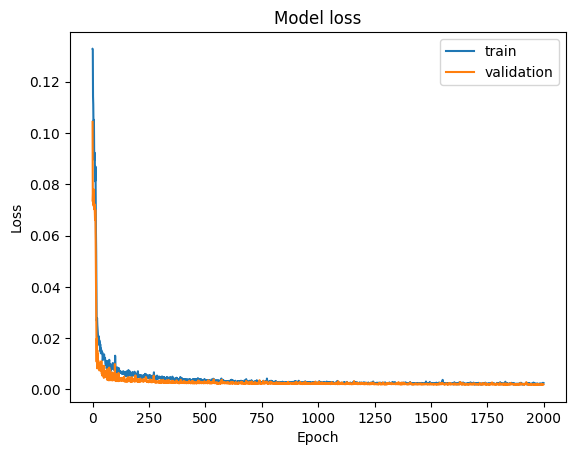

In [25]:
# Train the model
history = train_model(model, trainX, trainY, testX, testY)
# Graph loss and validation loss in one graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


7/7 [==============================] - 0s 2ms/step
MSE: 42.29829781144544 MAE: 5.0343636648691 MAPE: 1.9156972611587935 RMSE: 6.503714155115171 R2 Score: 0.9731314468459836


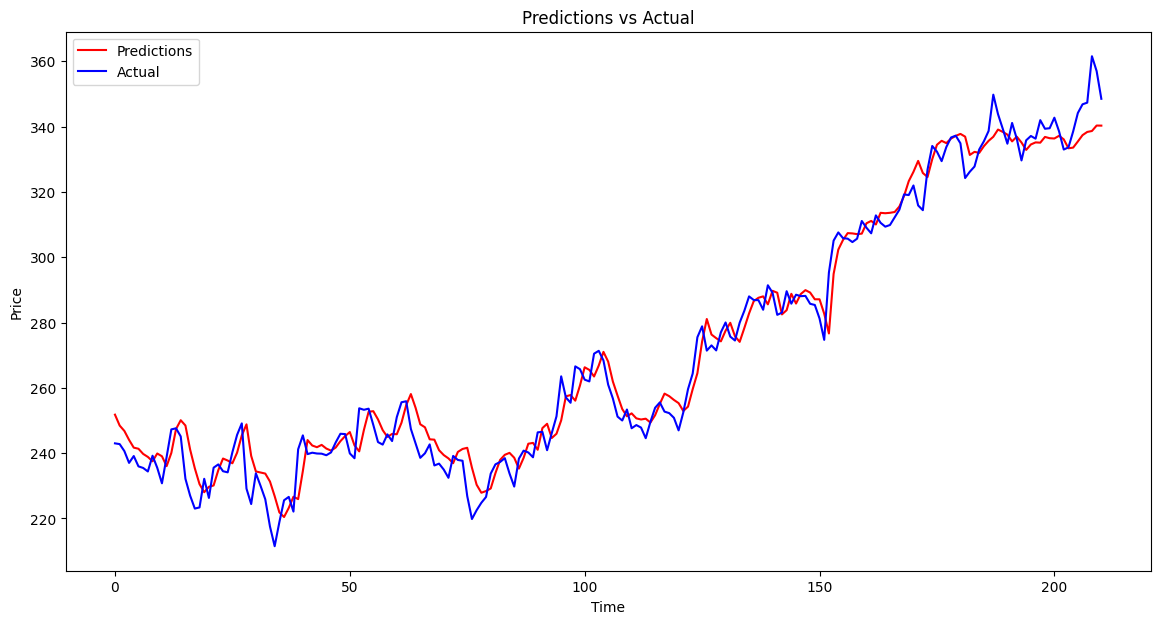

INFO:tensorflow:Assets written to: /Users/samuelzobev/Downloads/End of year project/trained_models/trained_model.h16/assets


INFO:tensorflow:Assets written to: /Users/samuelzobev/Downloads/End of year project/trained_models/trained_model.h16/assets


In [26]:
# Evaluate the model
from turtle import color


mse, mae, mape, rmse, r2_score, unscaled_predictions, unscaled_actual = evaluate_model(model, testX, testY, train_data, scaler, num_steps)
print('MSE:', mse, 'MAE:', mae, 'MAPE:', mape,'RMSE:', rmse, 'R2 Score:', r2_score)

# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(unscaled_predictions, label='Predictions', color='red')
plt.plot(unscaled_actual, label='Actual', color='blue')
plt.title('Predictions vs Actual')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc='upper left')
plt.show()

# Save the model
save_model(model)